確認資料

檢查你的前處理結果，是否每筆資料都有：

特徵 X（數字、向量、圖片...）

標籤 y（字母 A、B、C…）

In [59]:
import os
from PIL import Image
import numpy as np

path = "captcha_slice"
letters = os.listdir(path)
print("字母數：", len(letters))
print("前幾個字母資料夾：", letters[:10])

# 選一個字母資料夾，例如 'a'
sample_letter = letters[0]
letter_path = os.path.join(path, sample_letter)
images = os.listdir(letter_path)
print(f"'{sample_letter}' 的樣本數：", len(images))

# 讀取第一張圖片
sample_file = os.path.join(letter_path, images[0])
img = Image.open(sample_file)
arr = np.array(img)
print("圖片大小：", arr.shape)


字母數： 26
前幾個字母資料夾： ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
'a' 的樣本數： 151
圖片大小： (37, 31)


分資料

把資料切成三份：

訓練集（train）→ 給模型學習（約 80%）

驗證集（valid）→ 幫你挑好模型參數（約 10%）

測試集（test）→ 評估最終準確率（約 10%）

In [60]:
import os
import shutil
import random
from tqdm import tqdm

# 原始資料路徑
source_dir = "captcha_slice"
# 輸出目錄
output_dir = "data_split"
os.makedirs(output_dir, exist_ok=True)

# 訓練、驗證、測試比例
train_ratio = 0.8
valid_ratio = 0.1
test_ratio = 0.1

# 固定隨機種子（確保可重現）
random.seed(42)

# 針對每個字母資料夾做切分
for label in tqdm(os.listdir(source_dir)):
    label_dir = os.path.join(source_dir, label)
    if not os.path.isdir(label_dir):
        continue

    images = os.listdir(label_dir)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_valid = int(n_total * valid_ratio)

    # 切出三份
    train_files = images[:n_train]
    valid_files = images[n_train:n_train + n_valid]
    test_files = images[n_train + n_valid:]

    # 建立對應資料夾
    for subset_name, subset_files in [("train", train_files),
                                      ("valid", valid_files),
                                      ("test", test_files)]:
        subset_dir = os.path.join(output_dir, subset_name, label)
        os.makedirs(subset_dir, exist_ok=True)
        for fname in subset_files:
            src = os.path.join(label_dir, fname)
            dst = os.path.join(subset_dir, fname)
            shutil.copy2(src, dst)

print("分割完成！")


100%|██████████| 26/26 [00:02<00:00, 11.60it/s]

分割完成！


CNN 模型訓練

載入資料

In [61]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ================== 1) 資料增強 ==================
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),   # 建議字元用灰階
    transforms.Resize((64, 64)),
    transforms.RandomRotation(10),                 # ±10° 旋轉
    transforms.RandomAffine(degrees=0, shear=8),   # 斜體/剪切
    transforms.RandomPerspective(0.08, p=0.5),     # 透視扭曲
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 位移
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))           # 單通道標準化
])

# 驗證/測試：不要隨機變換，保持可重現
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ================== 2) 建立 Dataset ==================
train_data = datasets.ImageFolder('data_split/train', transform=train_transform)
valid_data = datasets.ImageFolder('data_split/valid', transform=test_transform)
test_data  = datasets.ImageFolder('data_split/test',  transform=test_transform)

# ================== 3) 建立 DataLoader ==================
pin_mem = torch.cuda.is_available()
train_loader = DataLoader(train_data, batch_size=32, shuffle=True,  num_workers=0, pin_memory=pin_mem)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=0, pin_memory=pin_mem)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False, num_workers=0, pin_memory=pin_mem)

print(f"訓練樣本：{len(train_data)}, 驗證樣本：{len(valid_data)}, 測試樣本：{len(test_data)}")
print(f"類別數量：{len(train_data.classes)}, 類別名稱：{train_data.classes}")


訓練樣本：1392, 驗證樣本：166, 測試樣本：194
類別數量：26, 類別名稱：['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


建立 CNN 模型

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# === 4層卷積版 ===
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        # Conv blocks
        self.conv1 = nn.Conv2d(1,   32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32,  64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # 第四層
        self.bn4   = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)  # 每層後都池化

        # 尺寸流：64→32→16→8→4，因此 in_features = 256*4*4
        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 64 -> 32
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 32 -> 16
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 16 -> 8
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # 8  -> 4
        x = x.view(x.size(0), -1)                       # (B, 256*4*4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# 建立模型
num_classes = len(train_data.classes)
model = ImprovedCNN(num_classes=num_classes).to(device)
print("✅ 4層卷積模型已載入：", device)


✅ 5層卷積模型已載入： cpu


訓練模型

In [78]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 驗證階段
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader):.4f}, Val Acc: {acc:.4f}")


KeyboardInterrupt: 

儲存與測試模型

In [76]:
# 儲存模型
torch.save(model.state_dict(), "cnn_model.pth")

# 測試集評估
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"測試集準確率：{correct / total:.4f}")


測試集準確率：0.8041


評估模型表現
用剛剛訓練好的模型（cnn_model.pth）對測試集進行預測，並計算：

 準確率 (Accuracy)

 F1-score（每個類別 + 平均）

 混淆矩陣（看看哪些字母最容易搞混）

Accuracy：0.8144
Macro F1-score：0.7894
a: 0.8000
b: 0.6667
c: 0.5000
d: 0.7273
e: 0.8667
f: 0.5000
g: 0.9091
h: 0.8235
i: 0.8108
j: 0.5000
k: 0.6667
l: 0.7692
m: 0.9091
n: 0.7273
o: 0.9286
p: 0.8889
q: 0.9091
r: 0.6667
s: 1.0000
t: 0.8000
u: 0.8824
v: 0.7273
w: 0.7143
x: 0.9231
y: 1.0000
z: 0.9091


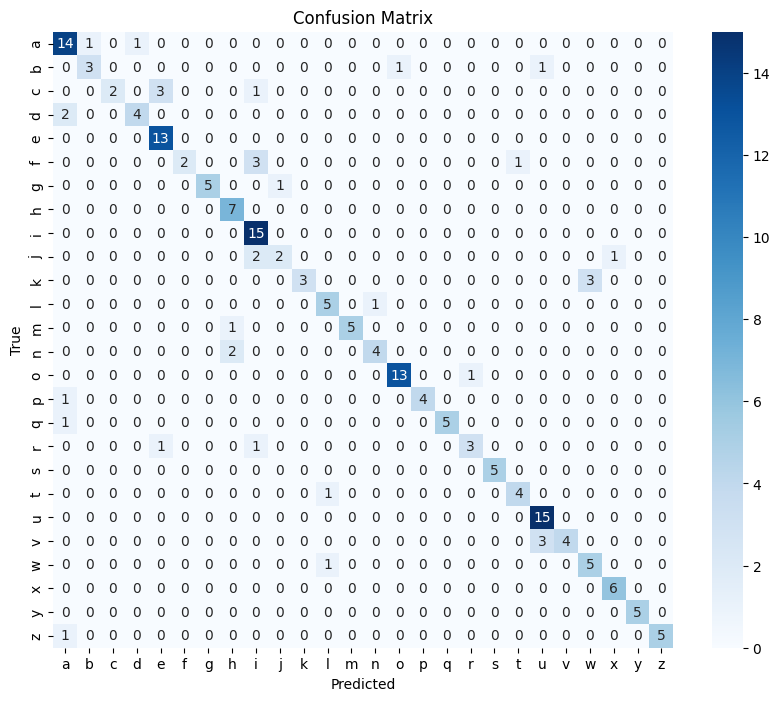


分類報告：
              precision    recall  f1-score   support

           a       0.74      0.88      0.80        16
           b       0.75      0.60      0.67         5
           c       1.00      0.33      0.50         6
           d       0.80      0.67      0.73         6
           e       0.76      1.00      0.87        13
           f       1.00      0.33      0.50         6
           g       1.00      0.83      0.91         6
           h       0.70      1.00      0.82         7
           i       0.68      1.00      0.81        15
           j       0.67      0.40      0.50         5
           k       1.00      0.50      0.67         6
           l       0.71      0.83      0.77         6
           m       1.00      0.83      0.91         6
           n       0.80      0.67      0.73         6
           o       0.93      0.93      0.93        14
           p       1.00      0.80      0.89         5
           q       1.00      0.83      0.91         6
           r       0

In [ ]:
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys, subprocess

# 升級安裝工具（可選，但建議）
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "pip", "wheel"])
# 安裝 seaborn
subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 載入模型（如果還沒載入）
model.load_state_dict(torch.load("cnn_model.pth", map_location=device))
model.to(device)
model.eval()

# 收集真實與預測標籤
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 轉成 numpy array
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ✅ 1️⃣ 準確率
acc = accuracy_score(all_labels, all_preds)
print(f"Accuracy：{acc:.4f}")

# ✅ 2️⃣ F1-score
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_each = f1_score(all_labels, all_preds, average=None)
print(f"Macro F1-score：{f1_macro:.4f}")

# 顯示每個類別的分數
classes = test_loader.dataset.classes
for c, f1 in zip(classes, f1_each):
    print(f"{c}: {f1:.4f}")

# ✅ 3️⃣ 混淆矩陣
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 額外：輸出詳細報告
print("\n分類報告")
print(classification_report(all_labels, all_preds, target_names=classes))
